<h1><center> Multiple Group Statistical Tests </center></h1>

The **MultiSampleTest** class provides includes different methods used for conducting different statistical tests on multigroup samples.
- **Variance Tests**: Using Bartlett's test to check the equality of variances across groups.
- **Mean Tests**: Conducts ANOVA or Welch's ANOVA based on the equality of variances to compare means across multiple groups.
- **Proportion Tests**: Uses the Chi-square test to evaluate the differences in proportions between categorical variables.
- **Distribution Tests**: Evaluates the signficance of distributional differences between categorical variables.
- **Linear Regression Analysis**: Performs simple linear regression to evaluate relationships between quantitative variables.

This class is ideal for data scientists, analysts, and researchers looking to perform comprehensive statistical analyses and create high-quality visual representations of their data.

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pingouin as pg
import scipy.stats as stats
from scipy.stats import chi2, f_oneway, bartlett, linregress
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

class MultiSampleTest:
    # Constructor
    def __init__(self, matrix, alpha):
        self.matrix = matrix
        self.alpha = alpha
        self.title = '{} for {}'
        # Define theme colors
        self.primary_color = '#5ec3e1'      # Light blue
        self.secondary_color = '#1f78b4'    # Dark blue
        self.highlight_color = '#e74c3c'    # Red
        self.background_color = '#001C30'   # Background color
        self.brand_colors = ['#00BFFF', '#1E90FF', '#00CED1'] # Additional brand colors

        # Set plot style
        sns.set_style("darkgrid")
        plt.style.use('seaborn-dark')

    def reg_values(self, gvar, vvar):
        regvalues = self.matrix.groupby(gvar)[vvar].agg(list).to_dict()
        return regvalues

    def MltVariance(self, gvar, vvar):
        # Grouping based on gvar
        y = self.reg_values(gvar, vvar)
        reg = self.matrix[gvar].unique()
        
        # Performing Bartlett's test
        F_obs, p_value = bartlett(y[reg[0]], y[reg[1]], y[reg[2]], y[reg[3]], y[reg[4]])

        # Plotting data with results annotation
        self.boxplot(gvar, vvar, F_obs, p_value, 'Variance Test')
        
        # Print results in the console
        self.print_results(F_obs, p_value, 'variance')

    def MltMean(self, gvar, vvar):
        # Grouping based on gvar
        y = self.reg_values(gvar, vvar)
        reg = self.matrix[gvar].unique()
        
        vartest = bartlett(y[reg[0]], y[reg[1]], y[reg[2]], y[reg[3]], y[reg[4]])

        # Equal Variance
        if vartest[1] >= self.alpha:
            F_obs, p_value = f_oneway(y[reg[0]], y[reg[1]], y[reg[2]], y[reg[3]], y[reg[4]])
        # Unequal Variance
        else:
            data = pd.DataFrame({'Var': self.matrix[vvar], 'Group': self.matrix[gvar]})
            welch = pg.welch_anova(dv='Var', between='Group', data=data)
            F_obs, p_value = float(welch['F']), float(welch['p-unc'])
            
        # Plotting data with results annotation
        self.barplot(gvar, vvar, F_obs, p_value, 'Mean Test')
        
        # Print results in the console
        self.print_results(F_obs, p_value, 'mean')

        if p_value < 0.05: 
            # At least one group is different
            tukeypairs = pairwise_tukeyhsd(self.matrix[vvar], self.matrix[gvar], alpha=0.01)
            print('\n', tukeypairs)  

    def MltProportion(self, var1, var2):
        table = self.matrix[[var1, var2]]
        
        CT = pd.crosstab(index=table[var2], columns=table[var1], rownames=[var2], colnames=[var1], margins=False).round(3)
        CT_prop = pd.crosstab(index=table[var2], columns=table[var1], rownames=[var2], colnames=[var1], margins=True, normalize='columns').round(3)
        
        # Chi-square test
        chi2, p_value, df, expectedFreq = stats.chi2_contingency(CT, correction=False)
        
        # Plot distribution with results annotation
        self.histplot(table, var1, var2, chi2, p_value, 'Proportion Test',palette=[self.primary_color,self.secondary_color])
        
        # Print results in the console
        self.print_results(chi2, p_value, 'proportion')

    def MltDistribution(self, var1, var2):
        table = self.matrix[[var1, var2]]

        CT = pd.crosstab(index=table[var2], columns=table[var1], rownames=[var2], colnames=[var1], margins=False).round(3)
        CT_prop = pd.crosstab(index=table[var2], columns=table[var1], rownames=[var2], colnames=[var1], margins=True, normalize='columns').round(3)

        # Chi-square test
        chi2, p_value, df, expectedFreq = stats.chi2_contingency(CT, correction=False)
        
        # Plot distribution with results annotation
        self.histplot(table, var1, var2, chi2, p_value, 'Distribution Test',self.brand_colors)
        
        # Print results in the console
        self.print_results(chi2, p_value, 'distribution')

    def LinearRegression(self, var1, var2):
        x = self.matrix[var1] 
        y = self.matrix[var2]

        nullityTest = linregress(x, y)
        b1 = nullityTest[0]  # slope
        b0 = nullityTest[1]  # intercept
        p_value = nullityTest[3].round(5)
        
        equation = f'y = {b1:.2f}x + {b0:.2f}'
        
        # Plotting regression line with results annotation
        self.regplot(var1, var2, b1, b0, p_value, equation)

        # Print results in the console
        print("\033[1;31m Conclusion:\033[0m")
        if p_value < self.alpha:
            print(f''' Since C.P = {p_value*100:.2f}% < α = {self.alpha*100}%, Reject H0: there is a significant linear relationship between {var1} and {var2} according to the {equation} equation.''')
        else:
            print(f''' Since C.P = {p_value*100:.2f}% > α = {self.alpha*100}%, Do not reject H0: there is no significant linear relationship between {var1} and {var2}''')

    # Visual plotting methods with annotations
    def histplot(self, data, var1, var2, stat_value, p_value, test_type,palette):
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.patch.set_facecolor(self.background_color)  # Set figure background color
        sns.histplot(data=data, x=var1, hue=var2, multiple='fill', stat='proportion', discrete=True, shrink=.3, 
                     palette=palette, ax=ax)  # Use custom palette
        legend = ax.legend(title=var2, labels=list(data[var2].unique()), bbox_to_anchor=(1.05, 1), loc=2, facecolor=self.background_color, edgecolor='white')
        plt.setp(legend.get_texts(), color='white')  # Set legend text color
        plt.title(f'{test_type}: {var1} vs. {var2}\nChi-Sq = {stat_value:.2f}, p = {p_value:.4f}', color='white')
        plt.xlabel(var1, color='white')
        plt.ylabel('Proportion', color='white')
        plt.xticks(color='white', fontsize=8, rotation=0, ha='center', fontweight='bold')
        plt.yticks(color='white', fontsize=8, fontweight='bold')
        ax.set_facecolor(self.background_color)  # Set axes background color
        
        # Set axes spines color
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        plt.tight_layout()
        plt.show()

    def boxplot(self, var1, var2, stat_value, p_value, test_type):
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.patch.set_facecolor(self.background_color)  # Set figure background color
        sns.boxplot(x=var1, y=var2, data=self.matrix, palette=self.brand_colors, ax=ax)  # Use custom palette
        plt.title(f'{test_type}: {var1} vs. {var2}\nF = {stat_value:.2f}, p = {p_value:.4f}', color='white')
        plt.xlabel(var1, fontsize=12, color='white')
        plt.ylabel(var2, fontsize=12, color='white')
        ax.set_facecolor(self.background_color)  # Set axes background color
        plt.xticks(color='white', fontsize=8, rotation=0, ha='center', fontweight='bold')
        plt.yticks(color='white', fontsize=8, fontweight='bold')
        
        # Set axes spines color
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        plt.tight_layout()
        plt.show()

    def barplot(self, var1, var2, stat_value, p_value, test_type):
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.patch.set_facecolor(self.background_color)  # Set figure background color
        sns.barplot(x=var1, y=var2, data=self.matrix, hue=var1,  errwidth=2, errcolor=self.highlight_color, capsize=0.2,
                    palette=self.brand_colors, ax=ax)  # Use brand colors for different groups
        plt.title(f'{test_type}: {var1} vs. {var2}\nF = {stat_value:.2f}, p = {p_value:.4f}', color='white')
        plt.xlabel(var1, fontsize=12, color='white')
        plt.ylabel(var2, fontsize=12, color='white')
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, facecolor=self.background_color, edgecolor='white')
        plt.setp(legend.get_texts(), color='white')  # Set legend text color
        ax.set_facecolor(self.background_color)  # Set axes background color
        plt.xticks(color='white', fontsize=8, rotation=0, ha='center', fontweight='bold')
        plt.yticks(color='white', fontsize=8, fontweight='bold')
        
        # Set axes spines color
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        plt.tight_layout()
        plt.show()

    def regplot(self, var1, var2, b1, b0, p_value, equation):
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.patch.set_facecolor(self.background_color)  # Set figure background color
        sns.regplot(x=self.matrix[var1], y=self.matrix[var2], scatter_kws={'color': self.primary_color,  's': 30}, color=self.highlight_color, ci=None , ax=ax)
        plt.title(f'Regression of {var2} on {var1}\n{equation}\np = {p_value:.4f}', color='white')
        plt.xlabel(var1, fontsize=12, color='white')
        plt.ylabel(var2, fontsize=12, color='white')
        ax.set_facecolor(self.background_color)  # Set axes background color
        plt.xticks(color='white', fontsize=8, rotation=0, ha='center', fontweight='bold')
        plt.yticks(color='white', fontsize=8, fontweight='bold')
        
        # Set axes spines color
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        plt.tight_layout()
        plt.show()

    def print_results(self, stat_value, p_value, test_type):
        print("\033[1;31m Results: \033[0m")
        print(f'\n -Test Type: {test_type}')
        print(f'\n -Statistic Value: {stat_value:.2f}')
        print(f'\n -p_Value: {p_value:.4f}')
        self.analysis(p_value, test_type)

    def analysis(self, CP, statistic):
        if CP < self.alpha:
            print(f''' Since C.P = {round(CP, 4) * 100:.2f}% < α = {self.alpha * 100:.2f}%, Reject H0: at least one group {statistic} is different from the others''')
        else:
            print(f''' Since C.P = {round(CP, 4) * 100:.2f}% > α = {self.alpha * 100:.2f}%, Do not reject H0: not enough proof that {statistic}s are different from the others''')

    # Additional methods and TestChoice method as previously defined...
    
    # Test choice method for user interaction
    def TestChoice(self, myChoice):
        if myChoice == '1':
            gvar = input('Enter Grouping Variable:')
            vvar = input('Enter Quantitative Variable:')
            self.MltMean(gvar, vvar)
        elif myChoice == '2':
            gvar = input('Enter Grouping Variable:')
            vvar = input('Enter Quantitative Variable:')
            self.MltVariance(gvar, vvar)
        elif myChoice == '3':
            var1 = input('Enter Grouping Variable:')
            var2 = input('Enter Dichotomous Variable:')
            self.MltProportion(var1, var2)
        elif myChoice == '4':
            var1 = input('Enter Grouping Variable:')
            var2 = input('Enter Nominal Variable:')
            self.MltDistribution(var1, var2)
        elif myChoice == '5':
            var1 = input('Enter 1st Quantitative Variable:')
            var2 = input('Enter 2nd Quantitative Variable:')
            self.LinearRegression(var1, var2)     
        else:
            self.plotDashboard()
    
    # Dashboard method to display all tests at once
    def plotDashboard(self):
        print("\n")
        self.MltMean('Illness', 'PPM')
        print("\n")
        self.MltVariance('Illness', 'PPM')
        print("\n")
        self.MltProportion('Illness', 'Gender')
        print("\n")
        self.MltDistribution('Illness', 'Age')
        print("\n")
        self.LinearRegression('Upper Tension', 'PPM')
        print("\n")
        self.LinearRegression('Lower Tension', 'PPM')


In [60]:
#read excel
pulse=pd.read_excel(r'Pulse.xlsx.')

pulse.rename(columns={'Sports activity':'Sports','Pulse Per Minute':'PPM'
                 },inplace = True)

pulse.head()

,Patient,Gender,Age,Sports,Smoker,Illness,PPM,Beat Regularity,Respiratory Rate,Lower Tension,Upper Tension,Temperature,Place of Living
0,1,Male,13-45,Yes,Yes,Cardiac,100,Regular,18,9.5,17.5,37.0,North
1,2,Male,13-45,Yes,Yes,Cardiac,45,Irregular,16,3.5,6.5,36.2,North
2,3,Female,> 45,No,Yes,Cardiac,85,Regular,20,9.5,14.5,36.5,North
3,4,Female,> 45,No,No,Cardiac,75,Irregular,16,6.5,12.5,37.8,North
4,5,Female,> 45,No,Yes,Cardiac,89,Regular,22,8.5,16.5,38.0,North


C:\Users\Youya\AppData\Local\Temp\ipykernel_9792\2757653738.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


Please Select Test from the List below:
               [1] Multi-Mean Test 
               [2] Multi-Variance Test
               [3] Multi-Proportion Test
               [4] Multi-Distribution Test
               [5] Linear Regression Test
               [6] Plot Dashboard

6




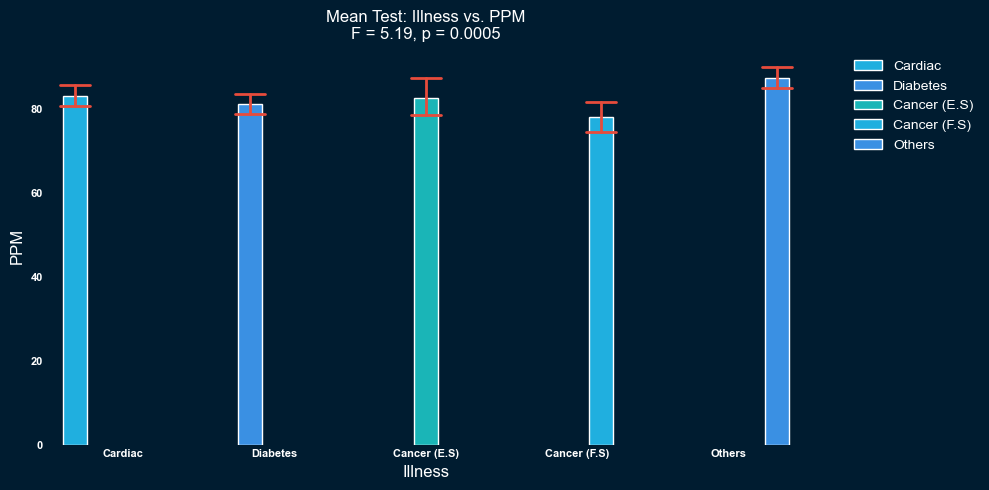

 Results: 

 -Test Type: mean

 -Statistic Value: 5.19

 -p_Value: 0.0005
 Since C.P = 0.05% < α = 5.00%, Reject H0: at least one group mean is different from the others

        Multiple Comparison of Means - Tukey HSD, FWER=0.01       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
Cancer (E.S) Cancer (F.S)  -4.5696 0.5494 -14.3919  5.2527  False
Cancer (E.S)      Cardiac   0.5662 0.9993  -7.1121  8.2446  False
Cancer (E.S)     Diabetes  -1.4317 0.9771  -9.4142  6.5508  False
Cancer (E.S)       Others   4.8137 0.2471  -2.8902 12.5176  False
Cancer (F.S)      Cardiac   5.1359 0.2842  -3.4046 13.6763  False
Cancer (F.S)     Diabetes   3.1379 0.7722   -5.677 11.9528  False
Cancer (F.S)       Others   9.3833 0.0034   0.8199 17.9468   True
     Cardiac     Diabetes  -1.9979 0.8414  -8.3369   4.341  False
     Cardiac       Others   4.2475 0.1399  -1.7369 10.2318  False
    Diabetes       Others   6.2454 0

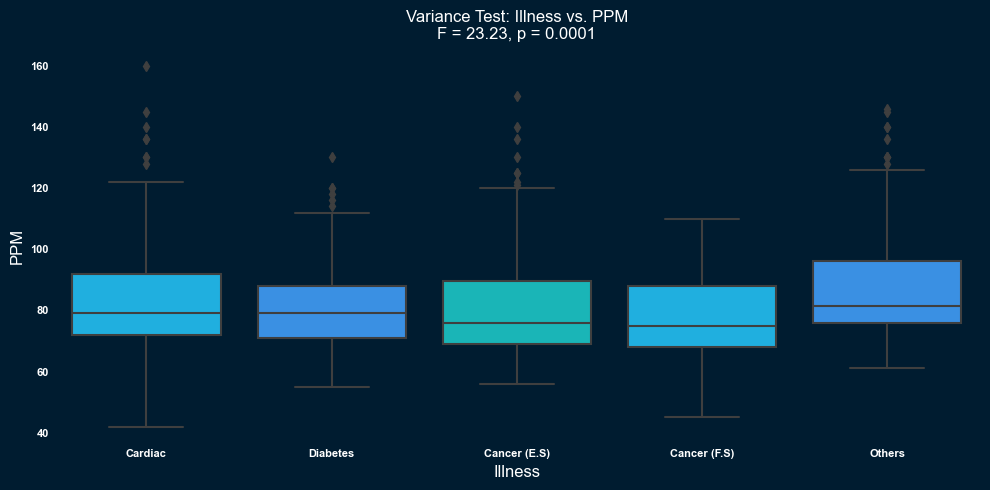

 Results: 

 -Test Type: variance

 -Statistic Value: 23.23

 -p_Value: 0.0001
 Since C.P = 0.01% < α = 5.00%, Reject H0: at least one group variance is different from the others




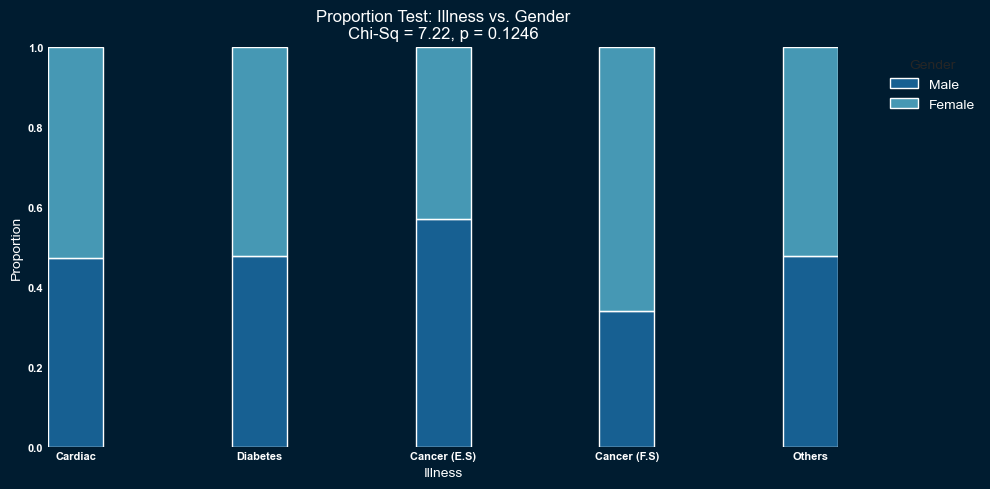

 Results: 

 -Test Type: proportion

 -Statistic Value: 7.22

 -p_Value: 0.1246
 Since C.P = 12.46% > α = 5.00%, Do not reject H0: not enough proof that proportions are different from the others




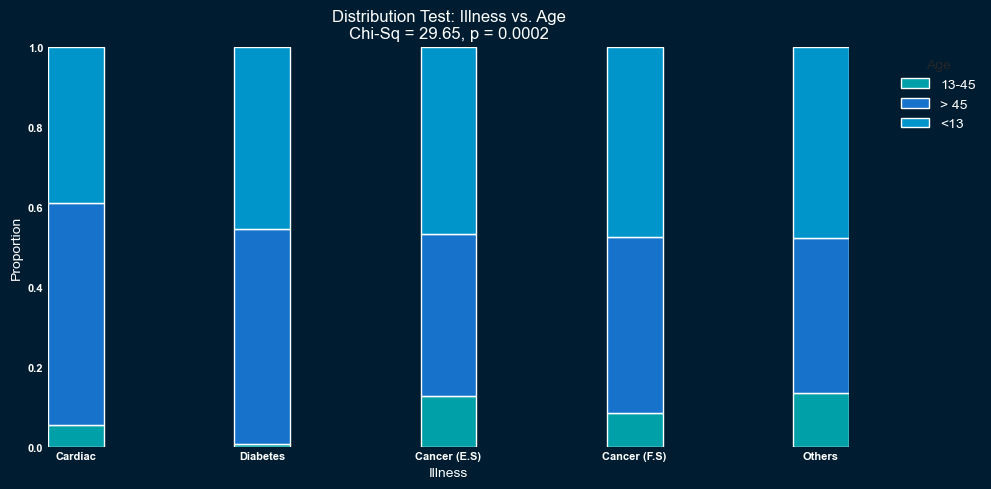

 Results: 

 -Test Type: distribution

 -Statistic Value: 29.65

 -p_Value: 0.0002
 Since C.P = 0.02% < α = 5.00%, Reject H0: at least one group distribution is different from the others




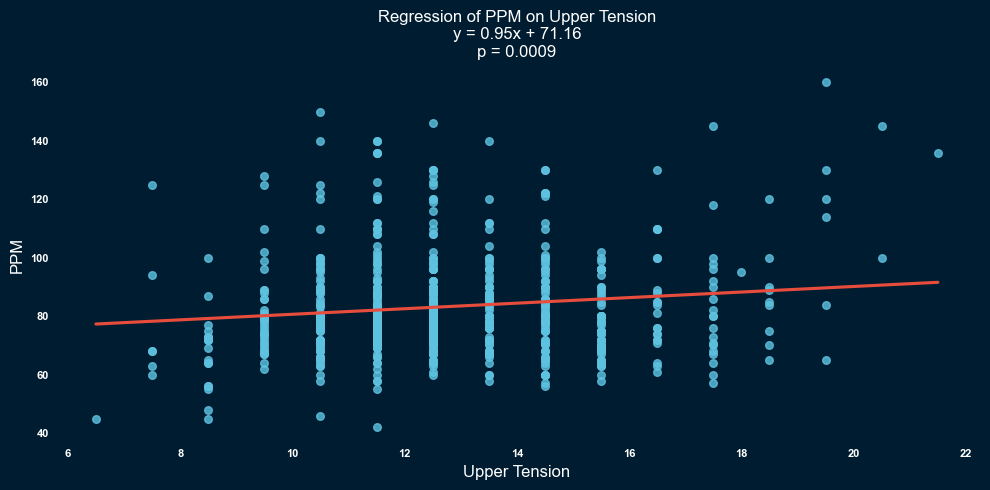

 Conclusion:
 Since C.P = 0.09% < α = 5.0%, Reject H0: there is a significant linear relationship between Upper Tension and PPM according to the y = 0.95x + 71.16 equation.




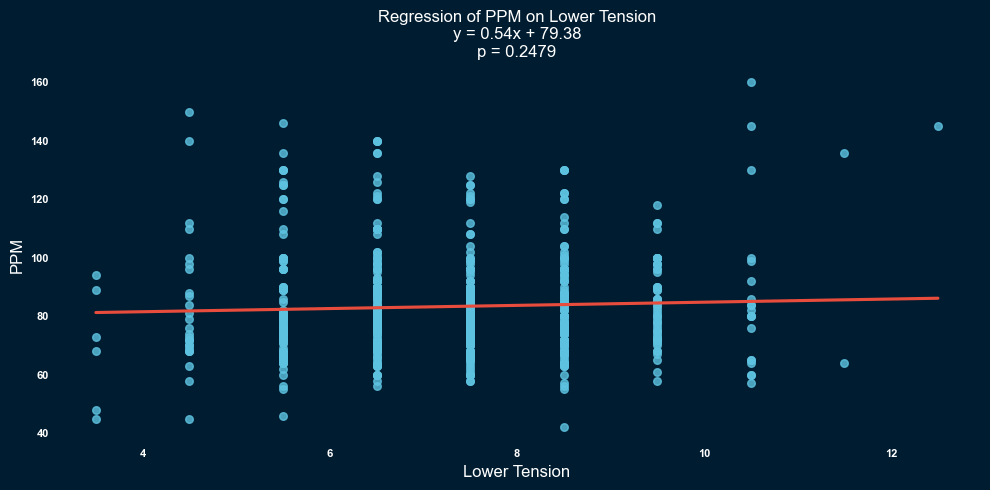

 Conclusion:
 Since C.P = 24.79% > α = 5.0%, Do not reject H0: there is no significant linear relationship between Lower Tension and PPM


In [61]:
alpha=0.05

mytest=MultiSampleTest(pulse,float(alpha))

#input 1, or 2 or 3 etc...
myChoice=input('''Please Select Test from the List below:
               [1] Multi-Mean Test 
               [2] Multi-Variance Test
               [3] Multi-Proportion Test
               [4] Multi-Distribution Test
               [5] Linear Regression Test
               [6] Plot Dashboard\n\n''')

mytest.TestChoice(myChoice)


